In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm


def RMSE(output, labels):
    return torch.sqrt(torch.mean((output - labels)**2)).item() 


def accuracy(output, labels):
    _, preds = torch.max(output, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)).item()


def train(
    model,
    train_loader,
    valid_loader,
    optimizer,
    criterion,
    device,
    epochs=10,
    log_writer=None,
    verbose=True,
    eval_metrics=[accuracy],
):

    eval_metric_names = [eval_metric.__name__ if (_:=eval_metric.__class__.__name__) == 'function' else _  for eval_metric in eval_metrics]

    history = {
        "train": {"loss": []},
        "valid": {"loss": []},
    }
    for eval_metric_name in eval_metric_names:
        history["train"][eval_metric_name] = []
        history["valid"][eval_metric_name] = []

    n = len(train_loader)
    model.to(device)
    for epoch in range(epochs):
        model.train()
        Loss_epoch = 0
        correct = {eval_metric_name: 0 for eval_metric_name in eval_metric_names}
        total = 0
        evaluation_train = {
            "loss": 0,
            **{eval_metric_name: 0 for eval_metric_name in eval_metric_names},
        }

        for idx, data in enumerate(tqdm(train_loader, disable=not verbose)):
            input, labels = data[0].to(device), data[1].to(device)
            # print(input.shape, labels.shape)
            
            
            optimizer.zero_grad()
            output = model(input)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            Loss_epoch += loss.item() * len(labels)

            for eval_metric, eval_metric_name in zip(eval_metrics, eval_metric_names):
                correct[eval_metric_name] += torch.tensor(eval_metric(output, labels)).item() * len(labels)
            total += len(labels)

        for eval_metric_name in eval_metric_names:
            evaluation_train[eval_metric_name] = correct[eval_metric_name] / total

        evaluation_train["loss"] = Loss_epoch / total
        evaluation_valid, *_ = evaluate(
            model, valid_loader, criterion, device, eval_metrics=eval_metrics
        )
        if verbose:
            print(
                f"epoch: {epoch}, train: {evaluation_train}, valid: {evaluation_valid}"
            )

        for eval_metric_name in eval_metric_names:
            history["train"][eval_metric_name].append(
                evaluation_train[eval_metric_name]
            )
            history["valid"][eval_metric_name].append(
                evaluation_valid[eval_metric_name]
            )

        history["train"]["loss"].append(evaluation_train["loss"])
        history["valid"]["loss"].append(evaluation_valid["loss"])

        if log_writer is not None:
            log_dict = {}
            for eval_metric_name in eval_metric_names:
                log_dict.update(
                    {
                        f"train/train_{eval_metric_name}": (
                            evaluation_train[eval_metric_name],
                            epoch,
                        ),
                        f"val/valid_{eval_metric_name}": (
                            evaluation_valid[eval_metric_name],
                            epoch,
                        ),
                    }
                )

            log_dict.update(
                {
                    "train/train_loss": (evaluation_train["loss"], epoch),
                    "val/valid_loss": (evaluation_valid["loss"], epoch),
                }
            )
            log_writer.log(log_dict)

    return history


def evaluate(
    model,
    data_loader,
    criterion,
    device,
    eval_metrics=[accuracy],
    return_preds=False,
    return_features=False,
):
    model.eval()
    eval_metric_names = [eval_metric.__name__ if (_:=eval_metric.__class__.__name__) == 'function' else _  for eval_metric in eval_metrics]
    metrics = {eval_metric_name: [] for eval_metric_name in eval_metric_names}
    Loss_history = []
    PREDS = []
    features = []
    ground_truth = []
    with torch.no_grad():
        for idx, data in enumerate(data_loader):
            input, target = data[0].to(device), data[1].to(device)
            if return_features:
                output, feature = model(input, get_features=True)
                features.extend(feature.tolist())
            output = model(input)
            loss = criterion(output, target)

            for eval_metric, eval_metric_name in zip(eval_metrics, eval_metric_names):
                metrics[eval_metric_name].append(eval_metric(output, target))

            Loss_history.append(loss.item())
            if return_preds:

                PREDS.extend(output.tolist())
            ground_truth.extend(target.tolist())
    return (
        {
            **{
                eval_metric_name: torch.mean(
                    torch.Tensor(metrics[eval_metric_name])
                ).item()
                for eval_metric_name in eval_metric_names
            },
            "loss": torch.mean(torch.Tensor(Loss_history)).item(),
        },
        PREDS,
        features,
        ground_truth,
    )

In [3]:
from torchvision.datasets import DatasetFolder, ImageFolder
from skimage import color
from torchvision.transforms import v2 as tt

In [4]:

data_transform = tt.Compose([
    tt.ToImage(),
    tt.Resize(size=(224, 224)),
    tt.RandomHorizontalFlip(p=0.5),
    tt.RandomRotation(degrees=45),
    tt.ToDtype(torch.float32,scale=1/255), 
])

from torchvision import datasets
train_data = datasets.ImageFolder(root="./hymenoptera_data/train", 
                                  transform=data_transform, 
                                  target_transform=None) 

test_data = datasets.ImageFolder(root="./hymenoptera_data/val", 
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 244
    Root location: ./hymenoptera_data/train
    StandardTransform
Transform: Compose(
                 ToImage()
                 Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=warn)
                 RandomHorizontalFlip(p=0.5)
                 RandomRotation(degrees=[-45.0, 45.0], interpolation=InterpolationMode.NEAREST, expand=False, fill=0)
                 ToDtype(scale=0.00392156862745098)
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 153
    Root location: ./hymenoptera_data/val
    StandardTransform
Transform: Compose(
                 ToImage()
                 Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=warn)
                 RandomHorizontalFlip(p=0.5)
                 RandomRotation(degrees=[-45.0, 45.0], interpolation=InterpolationMode.NEAREST, expand=False, fill=0)
                 ToDtype(scale=0.00392156862745098)
           )

In [5]:
def collate_fn_lab(data):
    rgb_images,_ = zip(*data)
    lab_images = [torch.tensor(color.rgb2lab(torch.permute(x,(1,2,0)))).permute(2,0,1) for x in rgb_images]
    return torch.stack(lab_images),torch.stack(rgb_images)


In [6]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset=train_data, 
                              batch_size=16, # how many samples per batch?
                            #   num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True,
                              collate_fn=collate_fn_lab) # shuffle the data?

test_loader = DataLoader(dataset=test_data, 
                             batch_size=8, 
                            #  num_workers=1, 
                             shuffle=False,
                             collate_fn=collate_fn_lab) # don't usually need to shuffle testing data

train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x204fc9b9ac0>,
 <torch.utils.data.dataloader.DataLoader at 0x204fc9b9310>)

In [7]:
img, label = next(iter(train_loader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

c:\Users\KHADGA JYOTH ALLI\.conda\envs\gpu\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Image shape: torch.Size([16, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([16, 3, 224, 224])


In [10]:
from torchmetrics.image import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio
torch.backends.cudnn.benchmark = True


class ConvAutoEncoder(nn.Module):
    def __init__(self,latent_dim=300):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=3, padding=1),
            nn.LeakyReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 8, 3, stride=2, padding=1),
            nn.LeakyReLU(True),
            nn.MaxPool2d(2, stride=1),
            nn.BatchNorm2d(8),
        #     nn.Flatten(),
        #     nn.Linear(8*18*18, latent_dim),
        #     nn.LeakyReLU(True)
        )

        self.decoder = nn.Sequential(
            # nn.Linear(latent_dim, 8*18*18),
            # nn.ReLU(),
            # nn.Unflatten(1, (8, 18, 18)),
            # nn.BatchNorm2d(8),
            nn.ConvTranspose2d(8, 8, 2, stride=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 16, 3, stride=2, padding=1),
            # nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 16, 2, stride=3),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 3, stride=3, padding=1),
            # nn.BatchNorm2d(3),
            nn.ReLU(True),
            
        )

    def forward(self, x, get_features=False):
        x = self.encoder(x)
        if get_features:
            return x, None
        x = self.decoder(x)
        return x[:, :, :224, :224]  # Crop the output to (3, 224, 224)

model = ConvAutoEncoder()
optimizer = optim.SGD(model.parameters(), lr=0.1)
criterion = nn.MSELoss() 
device = 'cuda'
writer = None
verbose = True
history = train(
    model, train_loader, test_loader, optimizer, criterion, device, epochs=50,log_writer = writer,verbose=True,eval_metrics=[RMSE,StructuralSimilarityIndexMeasure(data_range=1.0).to(device),PeakSignalNoiseRatio().to(device)]
)

  0%|          | 0/16 [00:00<?, ?it/s]

C:\Users\KHADGA JYOTH ALLI\AppData\Local\Temp\ipykernel_17352\2774313973.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct[eval_metric_name] += torch.tensor(eval_metric(output, labels)).item() * len(labels)
100%|██████████| 16/16 [00:06<00:00,  2.48it/s]


epoch: 0, train: {'loss': 0.18104108557349347, 'RMSE': 0.4243649224765965, 'StructuralSimilarityIndexMeasure': 0.030141123005601227, 'PeakSignalNoiseRatio': 7.468687792293361}, valid: {'RMSE': 0.3725157678127289, 'StructuralSimilarityIndexMeasure': 0.19764116406440735, 'PeakSignalNoiseRatio': 8.612406730651855, 'loss': 0.13994517922401428}


100%|██████████| 16/16 [00:06<00:00,  2.60it/s]


epoch: 1, train: {'loss': 0.1444774897860699, 'RMSE': 0.3794331120663002, 'StructuralSimilarityIndexMeasure': 0.035869138162644185, 'PeakSignalNoiseRatio': 8.432757596500585}, valid: {'RMSE': 0.3522505760192871, 'StructuralSimilarityIndexMeasure': 0.1850031167268753, 'PeakSignalNoiseRatio': 9.087782859802246, 'loss': 0.1247977465391159}


100%|██████████| 16/16 [00:06<00:00,  2.61it/s]


epoch: 2, train: {'loss': 0.13367346869628938, 'RMSE': 0.36522070697096526, 'StructuralSimilarityIndexMeasure': 0.04066404071254808, 'PeakSignalNoiseRatio': 8.758374823898565}, valid: {'RMSE': 0.34822413325309753, 'StructuralSimilarityIndexMeasure': 0.13413655757904053, 'PeakSignalNoiseRatio': 9.184430122375488, 'loss': 0.12186302244663239}


100%|██████████| 16/16 [00:06<00:00,  2.60it/s]


epoch: 3, train: {'loss': 0.1273144253941833, 'RMSE': 0.35602319777988994, 'StructuralSimilarityIndexMeasure': 0.04245806619769237, 'PeakSignalNoiseRatio': 8.989483270488801}, valid: {'RMSE': 0.34553974866867065, 'StructuralSimilarityIndexMeasure': 0.0754728615283966, 'PeakSignalNoiseRatio': 9.251906394958496, 'loss': 0.12000194936990738}


100%|██████████| 16/16 [00:06<00:00,  2.48it/s]


epoch: 4, train: {'loss': 0.1179358506056129, 'RMSE': 0.3426459451190761, 'StructuralSimilarityIndexMeasure': 0.04288578570866194, 'PeakSignalNoiseRatio': 9.322210171183603}, valid: {'RMSE': 0.3323817253112793, 'StructuralSimilarityIndexMeasure': 0.051974695175886154, 'PeakSignalNoiseRatio': 9.589873313903809, 'loss': 0.111062191426754}


100%|██████████| 16/16 [00:06<00:00,  2.57it/s]


epoch: 5, train: {'loss': 0.10693876872785756, 'RMSE': 0.32664540361185546, 'StructuralSimilarityIndexMeasure': 0.049926901266711655, 'PeakSignalNoiseRatio': 9.728353453464196}, valid: {'RMSE': 0.31986525654792786, 'StructuralSimilarityIndexMeasure': 0.05591931194067001, 'PeakSignalNoiseRatio': 9.928632736206055, 'loss': 0.10299991071224213}


100%|██████████| 16/16 [00:06<00:00,  2.51it/s]


epoch: 6, train: {'loss': 0.09949463691379203, 'RMSE': 0.31511012354835133, 'StructuralSimilarityIndexMeasure': 0.06256023879911078, 'PeakSignalNoiseRatio': 10.0398111968744}, valid: {'RMSE': 0.3132445812225342, 'StructuralSimilarityIndexMeasure': 0.0677265003323555, 'PeakSignalNoiseRatio': 10.11404037475586, 'loss': 0.09887056052684784}


100%|██████████| 16/16 [00:06<00:00,  2.57it/s]


epoch: 7, train: {'loss': 0.09663426607358651, 'RMSE': 0.3103614508128557, 'StructuralSimilarityIndexMeasure': 0.07512687574155995, 'PeakSignalNoiseRatio': 10.176485171083543}, valid: {'RMSE': 0.309410959482193, 'StructuralSimilarityIndexMeasure': 0.07981601357460022, 'PeakSignalNoiseRatio': 10.218855857849121, 'loss': 0.0964207798242569}


100%|██████████| 16/16 [00:06<00:00,  2.48it/s]


epoch: 8, train: {'loss': 0.09458844583542621, 'RMSE': 0.3067290944154145, 'StructuralSimilarityIndexMeasure': 0.09153499955036601, 'PeakSignalNoiseRatio': 10.287199520673909}, valid: {'RMSE': 0.3062167763710022, 'StructuralSimilarityIndexMeasure': 0.09748688340187073, 'PeakSignalNoiseRatio': 10.314949035644531, 'loss': 0.09457860141992569}


100%|██████████| 16/16 [00:06<00:00,  2.58it/s]


epoch: 9, train: {'loss': 0.09273286957721241, 'RMSE': 0.3040641785645094, 'StructuralSimilarityIndexMeasure': 0.1061092532071911, 'PeakSignalNoiseRatio': 10.353706547471344}, valid: {'RMSE': 0.30357861518859863, 'StructuralSimilarityIndexMeasure': 0.1117546558380127, 'PeakSignalNoiseRatio': 10.3909330368042, 'loss': 0.0929737463593483}


100%|██████████| 16/16 [00:06<00:00,  2.56it/s]


epoch: 10, train: {'loss': 0.0919082902494024, 'RMSE': 0.3025946470557666, 'StructuralSimilarityIndexMeasure': 0.11856416502936942, 'PeakSignalNoiseRatio': 10.398904362662893}, valid: {'RMSE': 0.3032040596008301, 'StructuralSimilarityIndexMeasure': 0.12364982068538666, 'PeakSignalNoiseRatio': 10.397850036621094, 'loss': 0.09266515076160431}


100%|██████████| 16/16 [00:06<00:00,  2.57it/s]


epoch: 11, train: {'loss': 0.09147604298396189, 'RMSE': 0.30202825294166313, 'StructuralSimilarityIndexMeasure': 0.1293217867124276, 'PeakSignalNoiseRatio': 10.411018824968181}, valid: {'RMSE': 0.3025325834751129, 'StructuralSimilarityIndexMeasure': 0.13312694430351257, 'PeakSignalNoiseRatio': 10.415454864501953, 'loss': 0.09221787750720978}


100%|██████████| 16/16 [00:06<00:00,  2.54it/s]


epoch: 12, train: {'loss': 0.09017144131367325, 'RMSE': 0.3000605194295039, 'StructuralSimilarityIndexMeasure': 0.13973268988679666, 'PeakSignalNoiseRatio': 10.462321750453262}, valid: {'RMSE': 0.3002443313598633, 'StructuralSimilarityIndexMeasure': 0.14749448001384735, 'PeakSignalNoiseRatio': 10.48808479309082, 'loss': 0.0909789428114891}


100%|██████████| 16/16 [00:06<00:00,  2.50it/s]


epoch: 13, train: {'loss': 0.089787842186748, 'RMSE': 0.2992746253482631, 'StructuralSimilarityIndexMeasure': 0.14871408558282695, 'PeakSignalNoiseRatio': 10.489346535479436}, valid: {'RMSE': 0.2998153269290924, 'StructuralSimilarityIndexMeasure': 0.1518261432647705, 'PeakSignalNoiseRatio': 10.496421813964844, 'loss': 0.09063257277011871}


100%|██████████| 16/16 [00:06<00:00,  2.59it/s]


epoch: 14, train: {'loss': 0.08887015502960956, 'RMSE': 0.297814421477865, 'StructuralSimilarityIndexMeasure': 0.15813611521095525, 'PeakSignalNoiseRatio': 10.529775353728748}, valid: {'RMSE': 0.2984216511249542, 'StructuralSimilarityIndexMeasure': 0.16102781891822815, 'PeakSignalNoiseRatio': 10.538508415222168, 'loss': 0.08981903642416}


100%|██████████| 16/16 [00:06<00:00,  2.59it/s]


epoch: 15, train: {'loss': 0.08864502266782229, 'RMSE': 0.2973849192017414, 'StructuralSimilarityIndexMeasure': 0.16506828123428782, 'PeakSignalNoiseRatio': 10.543792755877385}, valid: {'RMSE': 0.2983556091785431, 'StructuralSimilarityIndexMeasure': 0.17018261551856995, 'PeakSignalNoiseRatio': 10.54135513305664, 'loss': 0.08980558067560196}


100%|██████████| 16/16 [00:06<00:00,  2.57it/s]


epoch: 16, train: {'loss': 0.08942355752968398, 'RMSE': 0.2985065203221118, 'StructuralSimilarityIndexMeasure': 0.16762185756300316, 'PeakSignalNoiseRatio': 10.515869640913166}, valid: {'RMSE': 0.2969917058944702, 'StructuralSimilarityIndexMeasure': 0.1747901290655136, 'PeakSignalNoiseRatio': 10.582601547241211, 'loss': 0.08901610970497131}


100%|██████████| 16/16 [00:06<00:00,  2.65it/s]


epoch: 17, train: {'loss': 0.08866799378492793, 'RMSE': 0.2973712497070187, 'StructuralSimilarityIndexMeasure': 0.17640101323362256, 'PeakSignalNoiseRatio': 10.545719396872599}, valid: {'RMSE': 0.2973460257053375, 'StructuralSimilarityIndexMeasure': 0.17851552367210388, 'PeakSignalNoiseRatio': 10.568819999694824, 'loss': 0.08915392309427261}


100%|██████████| 16/16 [00:06<00:00,  2.50it/s]


epoch: 18, train: {'loss': 0.08826411210122656, 'RMSE': 0.2965494150021037, 'StructuralSimilarityIndexMeasure': 0.17945980097426742, 'PeakSignalNoiseRatio': 10.574115112179616}, valid: {'RMSE': 0.297839879989624, 'StructuralSimilarityIndexMeasure': 0.1814080774784088, 'PeakSignalNoiseRatio': 10.553644180297852, 'loss': 0.08943364769220352}


100%|██████████| 16/16 [00:06<00:00,  2.61it/s]


epoch: 19, train: {'loss': 0.08916797806493572, 'RMSE': 0.29835051346997743, 'StructuralSimilarityIndexMeasure': 0.18137900018301167, 'PeakSignalNoiseRatio': 10.513020484173884}, valid: {'RMSE': 0.2990051209926605, 'StructuralSimilarityIndexMeasure': 0.18576312065124512, 'PeakSignalNoiseRatio': 10.518937110900879, 'loss': 0.09012022614479065}


100%|██████████| 16/16 [00:06<00:00,  2.59it/s]


epoch: 20, train: {'loss': 0.08875336864444076, 'RMSE': 0.2976734633328485, 'StructuralSimilarityIndexMeasure': 0.18631663527645048, 'PeakSignalNoiseRatio': 10.5322633336802}, valid: {'RMSE': 0.297767698764801, 'StructuralSimilarityIndexMeasure': 0.19087600708007812, 'PeakSignalNoiseRatio': 10.559102058410645, 'loss': 0.08946692943572998}


100%|██████████| 16/16 [00:06<00:00,  2.55it/s]


epoch: 21, train: {'loss': 0.08809811340980843, 'RMSE': 0.29653194644412056, 'StructuralSimilarityIndexMeasure': 0.19074603182370545, 'PeakSignalNoiseRatio': 10.566867062302887}, valid: {'RMSE': 0.2960779070854187, 'StructuralSimilarityIndexMeasure': 0.19475027918815613, 'PeakSignalNoiseRatio': 10.608972549438477, 'loss': 0.08846491575241089}


100%|██████████| 16/16 [00:06<00:00,  2.57it/s]


epoch: 22, train: {'loss': 0.0878885338907359, 'RMSE': 0.29604996276683493, 'StructuralSimilarityIndexMeasure': 0.19216896471430045, 'PeakSignalNoiseRatio': 10.585263861984503}, valid: {'RMSE': 0.29827234148979187, 'StructuralSimilarityIndexMeasure': 0.19129332900047302, 'PeakSignalNoiseRatio': 10.54209041595459, 'loss': 0.08971838653087616}


100%|██████████| 16/16 [00:06<00:00,  2.53it/s]


epoch: 23, train: {'loss': 0.08828928626951624, 'RMSE': 0.2966888117008522, 'StructuralSimilarityIndexMeasure': 0.19627124755108943, 'PeakSignalNoiseRatio': 10.566971606895573}, valid: {'RMSE': 0.2973780035972595, 'StructuralSimilarityIndexMeasure': 0.19693931937217712, 'PeakSignalNoiseRatio': 10.571146011352539, 'loss': 0.08924563974142075}


100%|██████████| 16/16 [00:06<00:00,  2.61it/s]


epoch: 24, train: {'loss': 0.08788036664978402, 'RMSE': 0.2960499016965022, 'StructuralSimilarityIndexMeasure': 0.19779694324634114, 'PeakSignalNoiseRatio': 10.584194167715605}, valid: {'RMSE': 0.2976989150047302, 'StructuralSimilarityIndexMeasure': 0.1969805806875229, 'PeakSignalNoiseRatio': 10.557623863220215, 'loss': 0.08935274183750153}


100%|██████████| 16/16 [00:06<00:00,  2.57it/s]


epoch: 25, train: {'loss': 0.08751849683581805, 'RMSE': 0.2955040697191582, 'StructuralSimilarityIndexMeasure': 0.2012012596013116, 'PeakSignalNoiseRatio': 10.598426115317423}, valid: {'RMSE': 0.29611945152282715, 'StructuralSimilarityIndexMeasure': 0.20150232315063477, 'PeakSignalNoiseRatio': 10.608287811279297, 'loss': 0.08849668502807617}


100%|██████████| 16/16 [00:06<00:00,  2.58it/s]


epoch: 26, train: {'loss': 0.08811501132660225, 'RMSE': 0.29644253361420553, 'StructuralSimilarityIndexMeasure': 0.20182762429362439, 'PeakSignalNoiseRatio': 10.572595768287533}, valid: {'RMSE': 0.2973516583442688, 'StructuralSimilarityIndexMeasure': 0.2026829719543457, 'PeakSignalNoiseRatio': 10.56821346282959, 'loss': 0.08915575593709946}


100%|██████████| 16/16 [00:06<00:00,  2.56it/s]


epoch: 27, train: {'loss': 0.08778484275595086, 'RMSE': 0.29612467132630893, 'StructuralSimilarityIndexMeasure': 0.2027027431081553, 'PeakSignalNoiseRatio': 10.575215871216821}, valid: {'RMSE': 0.2972634434700012, 'StructuralSimilarityIndexMeasure': 0.20506694912910461, 'PeakSignalNoiseRatio': 10.572784423828125, 'loss': 0.08914388716220856}


100%|██████████| 16/16 [00:06<00:00,  2.63it/s]


epoch: 28, train: {'loss': 0.08782843170595951, 'RMSE': 0.29612412853319137, 'StructuralSimilarityIndexMeasure': 0.20217316536629787, 'PeakSignalNoiseRatio': 10.577564692888103}, valid: {'RMSE': 0.2970914840698242, 'StructuralSimilarityIndexMeasure': 0.20501336455345154, 'PeakSignalNoiseRatio': 10.579425811767578, 'loss': 0.08907479047775269}


100%|██████████| 16/16 [00:06<00:00,  2.64it/s]


epoch: 29, train: {'loss': 0.08835945070767012, 'RMSE': 0.29656887347580957, 'StructuralSimilarityIndexMeasure': 0.20641413428744332, 'PeakSignalNoiseRatio': 10.57716097597216}, valid: {'RMSE': 0.2959650754928589, 'StructuralSimilarityIndexMeasure': 0.20740178227424622, 'PeakSignalNoiseRatio': 10.610849380493164, 'loss': 0.08836345374584198}


100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


epoch: 30, train: {'loss': 0.0878016761824733, 'RMSE': 0.2959250612337081, 'StructuralSimilarityIndexMeasure': 0.2080119833594463, 'PeakSignalNoiseRatio': 10.587534185315741}, valid: {'RMSE': 0.29739102721214294, 'StructuralSimilarityIndexMeasure': 0.2098211795091629, 'PeakSignalNoiseRatio': 10.569658279418945, 'loss': 0.08922817558050156}


100%|██████████| 16/16 [00:06<00:00,  2.63it/s]


epoch: 31, train: {'loss': 0.08807126664724506, 'RMSE': 0.2962708502519326, 'StructuralSimilarityIndexMeasure': 0.20813484954052283, 'PeakSignalNoiseRatio': 10.58091260566086}, valid: {'RMSE': 0.2964085638523102, 'StructuralSimilarityIndexMeasure': 0.2077983319759369, 'PeakSignalNoiseRatio': 10.598312377929688, 'loss': 0.08863796293735504}


100%|██████████| 16/16 [00:06<00:00,  2.55it/s]


epoch: 32, train: {'loss': 0.08794484666136444, 'RMSE': 0.2960134515019714, 'StructuralSimilarityIndexMeasure': 0.20785077331496066, 'PeakSignalNoiseRatio': 10.589142611769379}, valid: {'RMSE': 0.2968321144580841, 'StructuralSimilarityIndexMeasure': 0.21248674392700195, 'PeakSignalNoiseRatio': 10.585103988647461, 'loss': 0.08888189494609833}


100%|██████████| 16/16 [00:06<00:00,  2.60it/s]


epoch: 33, train: {'loss': 0.08748901904117866, 'RMSE': 0.2953760965925748, 'StructuralSimilarityIndexMeasure': 0.21180321300616028, 'PeakSignalNoiseRatio': 10.604454556449515}, valid: {'RMSE': 0.29650750756263733, 'StructuralSimilarityIndexMeasure': 0.21191814541816711, 'PeakSignalNoiseRatio': 10.594694137573242, 'loss': 0.08868064731359482}


100%|██████████| 16/16 [00:06<00:00,  2.62it/s]


epoch: 34, train: {'loss': 0.08696000473421128, 'RMSE': 0.29427401697049377, 'StructuralSimilarityIndexMeasure': 0.21259536801791581, 'PeakSignalNoiseRatio': 10.643621554140184}, valid: {'RMSE': 0.29609137773513794, 'StructuralSimilarityIndexMeasure': 0.21118707954883575, 'PeakSignalNoiseRatio': 10.604776382446289, 'loss': 0.08839289098978043}


100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


epoch: 35, train: {'loss': 0.08746521553543747, 'RMSE': 0.29549486275579107, 'StructuralSimilarityIndexMeasure': 0.21160815240906888, 'PeakSignalNoiseRatio': 10.596330673968206}, valid: {'RMSE': 0.29539674520492554, 'StructuralSimilarityIndexMeasure': 0.21120741963386536, 'PeakSignalNoiseRatio': 10.628318786621094, 'loss': 0.08804593235254288}


100%|██████████| 16/16 [00:06<00:00,  2.58it/s]


epoch: 36, train: {'loss': 0.0876139864081242, 'RMSE': 0.2955808810523299, 'StructuralSimilarityIndexMeasure': 0.21178878330793538, 'PeakSignalNoiseRatio': 10.598711045061956}, valid: {'RMSE': 0.29506558179855347, 'StructuralSimilarityIndexMeasure': 0.21335501968860626, 'PeakSignalNoiseRatio': 10.637375831604004, 'loss': 0.08783052861690521}


100%|██████████| 16/16 [00:06<00:00,  2.56it/s]


epoch: 37, train: {'loss': 0.08776540187050084, 'RMSE': 0.2958047355784745, 'StructuralSimilarityIndexMeasure': 0.21186864229499316, 'PeakSignalNoiseRatio': 10.593307495117188}, valid: {'RMSE': 0.29600614309310913, 'StructuralSimilarityIndexMeasure': 0.21260610222816467, 'PeakSignalNoiseRatio': 10.608977317810059, 'loss': 0.08837662637233734}


100%|██████████| 16/16 [00:06<00:00,  2.56it/s]


epoch: 38, train: {'loss': 0.08802174092804799, 'RMSE': 0.2964968827904248, 'StructuralSimilarityIndexMeasure': 0.21194471809707705, 'PeakSignalNoiseRatio': 10.565165269570272}, valid: {'RMSE': 0.29678022861480713, 'StructuralSimilarityIndexMeasure': 0.20910203456878662, 'PeakSignalNoiseRatio': 10.586198806762695, 'loss': 0.08884087949991226}


100%|██████████| 16/16 [00:06<00:00,  2.59it/s]


epoch: 39, train: {'loss': 0.08743199767147908, 'RMSE': 0.2949392250815376, 'StructuralSimilarityIndexMeasure': 0.21173360064381458, 'PeakSignalNoiseRatio': 10.627673508691005}, valid: {'RMSE': 0.29526418447494507, 'StructuralSimilarityIndexMeasure': 0.2133454531431198, 'PeakSignalNoiseRatio': 10.631036758422852, 'loss': 0.08794327825307846}


100%|██████████| 16/16 [00:06<00:00,  2.59it/s]


epoch: 40, train: {'loss': 0.08729883100165696, 'RMSE': 0.2952202284922365, 'StructuralSimilarityIndexMeasure': 0.21440482383868734, 'PeakSignalNoiseRatio': 10.604229770722936}, valid: {'RMSE': 0.2964076101779938, 'StructuralSimilarityIndexMeasure': 0.2110767364501953, 'PeakSignalNoiseRatio': 10.59851360321045, 'loss': 0.08864492177963257}


100%|██████████| 16/16 [00:06<00:00,  2.50it/s]


epoch: 41, train: {'loss': 0.0878830156365379, 'RMSE': 0.2960808130561328, 'StructuralSimilarityIndexMeasure': 0.21167799586155375, 'PeakSignalNoiseRatio': 10.582224705180185}, valid: {'RMSE': 0.2962297797203064, 'StructuralSimilarityIndexMeasure': 0.21352413296699524, 'PeakSignalNoiseRatio': 10.60183334350586, 'loss': 0.08849862217903137}


100%|██████████| 16/16 [00:06<00:00,  2.60it/s]


epoch: 42, train: {'loss': 0.08720125282397036, 'RMSE': 0.29487595988101645, 'StructuralSimilarityIndexMeasure': 0.2145198705743571, 'PeakSignalNoiseRatio': 10.619534336152624}, valid: {'RMSE': 0.29738718271255493, 'StructuralSimilarityIndexMeasure': 0.21462607383728027, 'PeakSignalNoiseRatio': 10.568053245544434, 'loss': 0.08919607102870941}


100%|██████████| 16/16 [00:06<00:00,  2.50it/s]


epoch: 43, train: {'loss': 0.08754605860983738, 'RMSE': 0.29545505271583306, 'StructuralSimilarityIndexMeasure': 0.2111449747300539, 'PeakSignalNoiseRatio': 10.60243372057305}, valid: {'RMSE': 0.2949829697608948, 'StructuralSimilarityIndexMeasure': 0.215002179145813, 'PeakSignalNoiseRatio': 10.63833999633789, 'loss': 0.08775459229946136}


100%|██████████| 16/16 [00:06<00:00,  2.58it/s]


epoch: 44, train: {'loss': 0.08747642646070386, 'RMSE': 0.29517314570849057, 'StructuralSimilarityIndexMeasure': 0.21242046747051302, 'PeakSignalNoiseRatio': 10.614990844101202}, valid: {'RMSE': 0.2950522303581238, 'StructuralSimilarityIndexMeasure': 0.21549935638904572, 'PeakSignalNoiseRatio': 10.638723373413086, 'loss': 0.0878380537033081}


100%|██████████| 16/16 [00:06<00:00,  2.55it/s]


epoch: 45, train: {'loss': 0.08754027842498216, 'RMSE': 0.2955514471061894, 'StructuralSimilarityIndexMeasure': 0.21264653518551685, 'PeakSignalNoiseRatio': 10.596690975251745}, valid: {'RMSE': 0.29476237297058105, 'StructuralSimilarityIndexMeasure': 0.21425266563892365, 'PeakSignalNoiseRatio': 10.646173477172852, 'loss': 0.08764868229627609}


100%|██████████| 16/16 [00:06<00:00,  2.54it/s]


epoch: 46, train: {'loss': 0.08686687882806433, 'RMSE': 0.2944626402659494, 'StructuralSimilarityIndexMeasure': 0.21325673187365296, 'PeakSignalNoiseRatio': 10.627300762739338}, valid: {'RMSE': 0.29541847109794617, 'StructuralSimilarityIndexMeasure': 0.2148604393005371, 'PeakSignalNoiseRatio': 10.62641429901123, 'loss': 0.0880308598279953}


100%|██████████| 16/16 [00:06<00:00,  2.62it/s]


epoch: 47, train: {'loss': 0.08698885973359717, 'RMSE': 0.29465549451405887, 'StructuralSimilarityIndexMeasure': 0.21300619645196883, 'PeakSignalNoiseRatio': 10.622006885340957}, valid: {'RMSE': 0.29578420519828796, 'StructuralSimilarityIndexMeasure': 0.2143440693616867, 'PeakSignalNoiseRatio': 10.61713981628418, 'loss': 0.08828316628932953}


100%|██████████| 16/16 [00:06<00:00,  2.54it/s]


epoch: 48, train: {'loss': 0.08722591045938555, 'RMSE': 0.29502443163121334, 'StructuralSimilarityIndexMeasure': 0.2106561032963581, 'PeakSignalNoiseRatio': 10.61206980220607}, valid: {'RMSE': 0.2942289710044861, 'StructuralSimilarityIndexMeasure': 0.21550758183002472, 'PeakSignalNoiseRatio': 10.662747383117676, 'loss': 0.08735538274049759}


100%|██████████| 16/16 [00:06<00:00,  2.56it/s]


epoch: 49, train: {'loss': 0.08717564725485004, 'RMSE': 0.2946843436506928, 'StructuralSimilarityIndexMeasure': 0.2135009575085562, 'PeakSignalNoiseRatio': 10.62976990371454}, valid: {'RMSE': 0.29549726843833923, 'StructuralSimilarityIndexMeasure': 0.21524584293365479, 'PeakSignalNoiseRatio': 10.625907897949219, 'loss': 0.0881182923913002}


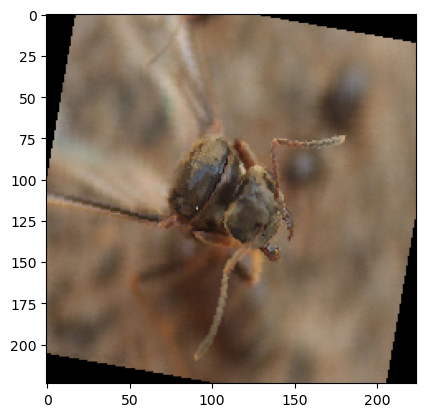

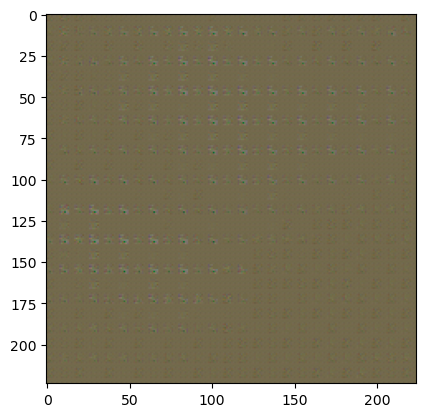

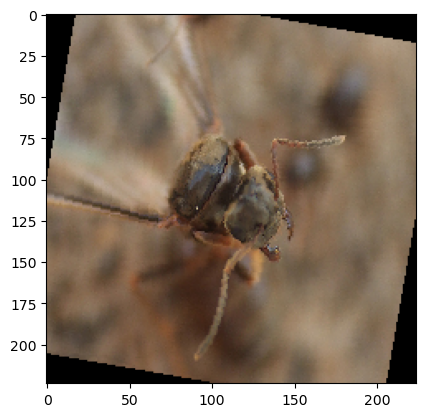

In [11]:
for img, _ in test_loader:
    img = img.to(device)
    output = model(img)
    plt.imshow(_[1].permute(1,2,0).cpu().detach().numpy())
    plt.show()
    plt.imshow(output[1].permute(1,2,0).cpu().detach().numpy())
    plt.show()
    plt.imshow(color.lab2rgb(img[1].permute(1,2,0).cpu().detach().numpy()))
    break